<a href="https://colab.research.google.com/github/Chovy-Culver/weatherwise-Chufengsheng-Zheng-doe/blob/main/WeatherWise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [299]:
# Create a config.py file with the API key
with open("config.py", "w") as f:
    f.write('API_KEY = "1da7dea923d784a5dd83bac94cde8d65"')


In [300]:
from config import API_KEY

print("Your API Key is:", API_KEY)

Your API Key is: 1da7dea923d784a5dd83bac94cde8d65


In [301]:
!mkdir -p weather_data  # create catalog

fetch_code = """
\"""fetch.py - Module for retrieving weather data from OpenWeatherMap API.\"""

import requests
from config import API_KEY

BASE_URL = "https://api.openweathermap.org/data/2.5/"

def fetch_current_weather(city):
    \"\"\"Fetch current weather data for a given city.\"\"\"
    url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    return response.json() if response.status_code == 200 else None

def fetch_forecast_weather(city):
    \"\"\"Fetch 5-day forecast data (3-hour intervals) for a given city.\"\"\"
    url = f"{BASE_URL}forecast?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    return response.json() if response.status_code == 200 else None
"""

with open("weather_data/fetch.py", "w") as f:
    f.write(fetch_code)


In [302]:
import sys
sys.path.append('/content')


In [303]:
from weather_data.fetch import fetch_current_weather

city = "Perth"
data = fetch_current_weather(city)

print(data if data else "❌ Failed to fetch weather.")


{'coord': {'lon': 115.8333, 'lat': -31.9333}, 'weather': [{'id': 520, 'main': 'Rain', 'description': 'light intensity shower rain', 'icon': '09n'}], 'base': 'stations', 'main': {'temp': 18.15, 'feels_like': 17.93, 'temp_min': 16, 'temp_max': 19.54, 'pressure': 1015, 'humidity': 73, 'sea_level': 1015, 'grnd_level': 1012}, 'visibility': 10000, 'wind': {'speed': 7.15, 'deg': 202, 'gust': 13.86}, 'rain': {'1h': 1.06}, 'clouds': {'all': 75}, 'dt': 1747924622, 'sys': {'type': 2, 'id': 63154, 'country': 'AU', 'sunrise': 1747868560, 'sunset': 1747905856}, 'timezone': 28800, 'id': 2063523, 'name': 'Perth', 'cod': 200}


In [304]:
# create file
!mkdir -p weather_data

# import visualise.py
visualise_code = """
\"\"\"visualise.py - Module for visualising weather forecast data.\"\"\"

import matplotlib.pyplot as plt
from datetime import datetime

def plot_temperature_trend(forecast_data, city):
    times = []
    temps = []
    for entry in forecast_data['list']:
        dt = datetime.strptime(entry['dt_txt'], "%Y-%m-%d %H:%M:%S")
        temp = entry['main']['temp']
        times.append(dt)
        temps.append(temp)
    plt.figure(figsize=(10, 5))
    plt.plot(times, temps, marker='o')
    plt.title(f"Temperature Trend in {city}")
    plt.xlabel("Date & Time")
    plt.ylabel("Temperature (°C)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def plot_precipitation_probability(forecast_data, city):
    times = []
    probs = []
    for entry in forecast_data['list']:
        dt = datetime.strptime(entry['dt_txt'], "%Y-%m-%d %H:%M:%S")
        prob = entry.get('pop', 0) * 100
        times.append(dt)
        probs.append(prob)
    plt.figure(figsize=(10, 5))
    plt.bar(times, probs)
    plt.title(f"Precipitation Probability in {city}")
    plt.xlabel("Date & Time")
    plt.ylabel("Probability (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def plot_wind_speed(forecast_data, city):
    times = []
    speeds = []
    for entry in forecast_data['list']:
        dt = datetime.strptime(entry['dt_txt'], "%Y-%m-%d %H:%M:%S")
        speed = entry['wind']['speed']
        times.append(dt)
        speeds.append(speed)
    plt.figure(figsize=(10, 5))
    plt.plot(times, speeds, marker='s', linestyle='--')
    plt.title(f"Wind Speed Forecast in {city}")
    plt.xlabel("Date & Time")
    plt.ylabel("Wind Speed (m/s)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()
"""

with open("weather_data/visualise.py", "w") as f:
    f.write(visualise_code)


In [305]:
import sys
sys.path.append('/content')


In [306]:
from weather_data.visualise import (
    plot_temperature_trend,
    plot_precipitation_probability,
    plot_wind_speed
)
print("✅ visualise module imported successfully.")


✅ visualise module imported successfully.


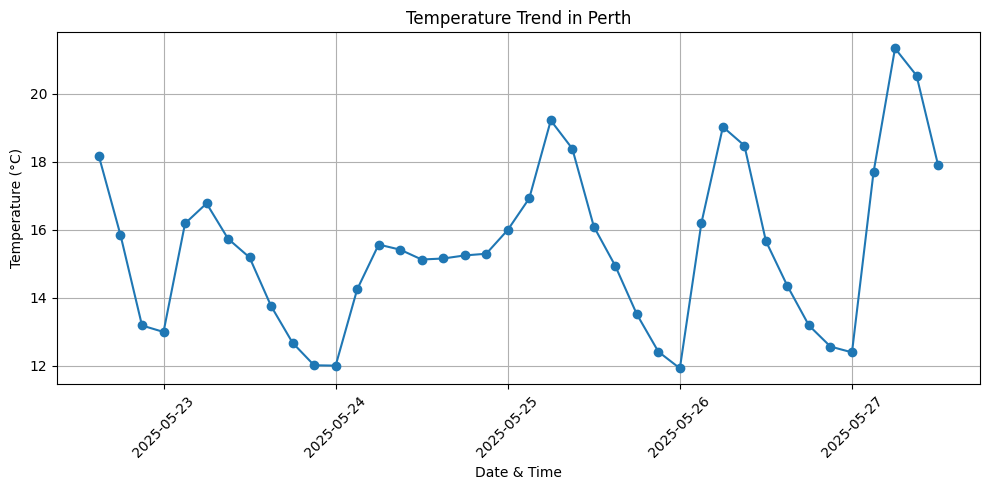

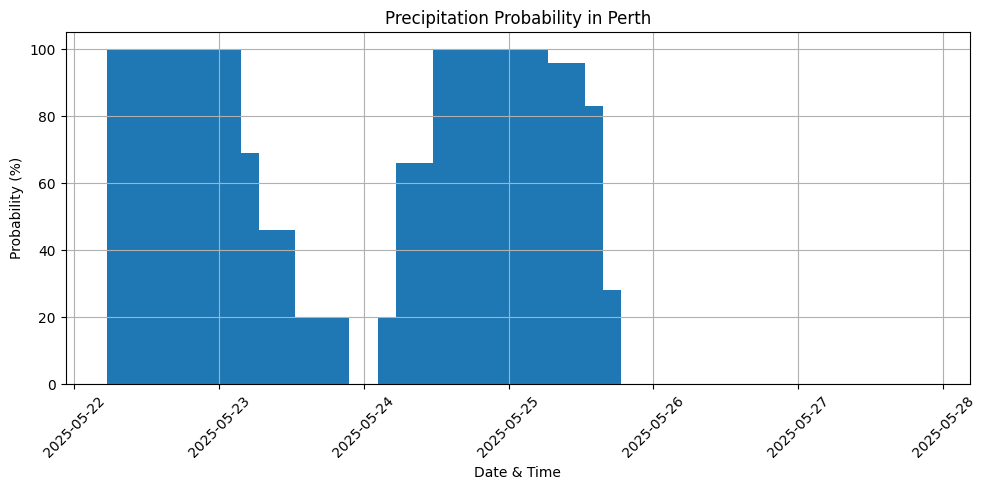

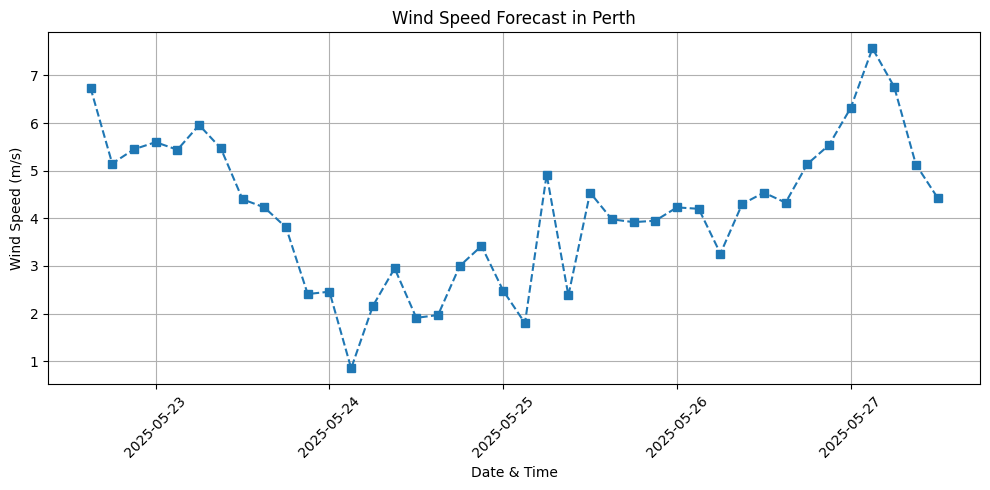

In [307]:
from weather_data.fetch import fetch_forecast_weather
from weather_data.visualise import (
    plot_temperature_trend,
    plot_precipitation_probability,
    plot_wind_speed
)

city = "Perth"
forecast = fetch_forecast_weather(city)

if forecast:
    plot_temperature_trend(forecast, city)
    plot_precipitation_probability(forecast, city)
    plot_wind_speed(forecast, city)
else:
    print("❌ Failed to fetch forecast data.")


In [308]:
parser_code = '''"""
parser.py - Smart parser for weather intent and time keyword detection.
"""

from difflib import get_close_matches
import re

INTENT_KEYWORDS = {
    "temperature": ["cold", "hot", "temperature", "jacket", "coat", "sweater", "warm", "cool", "wear"],
    "rain": ["rain", "umbrella", "wet", "drizzle"],
    "wind": ["wind", "windy", "breeze", "gust"]
}

TIME_KEYWORDS = {
    "today": ["today", "now", "currently"],
    "tomorrow": ["tomorrow", "next day"],
    "day after tomorrow": ["day after tomorrow"]
}

KEYWORD_TO_INTENT = {k: intent for intent, lst in INTENT_KEYWORDS.items() for k in lst}
KEYWORD_TO_TIME = {k: time for time, lst in TIME_KEYWORDS.items() for k in lst}

def infer_weather_intent(user_input):
    words = re.findall(r'\\w+', user_input.lower())
    for word in words:
        if word in KEYWORD_TO_INTENT:
            return KEYWORD_TO_INTENT[word]
        match = get_close_matches(word, KEYWORD_TO_INTENT.keys(), n=1, cutoff=0.8)
        if match:
            return KEYWORD_TO_INTENT[match[0]]
    return None

def infer_time_keyword(user_input):
    words = re.findall(r'\\w+', user_input.lower())
    for word in words:
        if word in KEYWORD_TO_TIME:
            return KEYWORD_TO_TIME[word]
        match = get_close_matches(word, KEYWORD_TO_TIME.keys(), n=1, cutoff=0.8)
        if match:
            return KEYWORD_TO_TIME[match[0]]
    return None
'''

with open("/content/nlp_interface/parser.py", "w", encoding="utf-8") as f:
    f.write(parser_code)

print("✅ parser.py has been fully rewritten.")


✅ parser.py has been fully rewritten.


In [309]:
with open("/content/nlp_interface/parser.py", "w") as f:
    f.write(parser_code)


In [310]:
%cat /content/nlp_interface/parser.py


"""
parser.py - Smart parser for weather intent and time keyword detection.
"""

from difflib import get_close_matches
import re

INTENT_KEYWORDS = {
    "temperature": ["cold", "hot", "temperature", "jacket", "coat", "sweater", "warm", "cool", "wear"],
    "rain": ["rain", "umbrella", "wet", "drizzle"],
    "wind": ["wind", "windy", "breeze", "gust"]
}

TIME_KEYWORDS = {
    "today": ["today", "now", "currently"],
    "tomorrow": ["tomorrow", "next day"],
    "day after tomorrow": ["day after tomorrow"]
}

KEYWORD_TO_INTENT = {k: intent for intent, lst in INTENT_KEYWORDS.items() for k in lst}
KEYWORD_TO_TIME = {k: time for time, lst in TIME_KEYWORDS.items() for k in lst}

def infer_weather_intent(user_input):
    words = re.findall(r'\w+', user_input.lower())
    for word in words:
        if word in KEYWORD_TO_INTENT:
            return KEYWORD_TO_INTENT[word]
        match = get_close_matches(word, KEYWORD_TO_INTENT.keys(), n=1, cutoff=0.8)
        if match:
            return KEYWO

In [311]:
pip install pyinputplus


In [312]:
import os

# Make sure the ui/ directory exists
os.makedirs("/content/ui", exist_ok=True)

# Now write the clean English version of menu.py
menu_code = '''"""
menu.py - Interactive weather application menu using pyinputplus.
"""

import pyinputplus as pyip
from weather_data.fetch import fetch_current_weather, fetch_forecast_weather
from weather_data.visualise import (
    plot_temperature_trend,
    plot_precipitation_probability,
    plot_wind_speed
)
from nlp_interface.parser import infer_weather_intent
from nlp_interface.responder import generate_response
from ui.display import show_weather_info, show_error

def handle_check_weather():
    city = pyip.inputStr("Enter a city name: ")
    data = fetch_current_weather(city)
    if data:
        show_weather_info(data)
    else:
        show_error("Could not retrieve current weather data.")

def handle_show_charts():
    city = pyip.inputStr("Enter a city name: ")
    forecast = fetch_forecast_weather(city)
    if not forecast:
        show_error("Could not retrieve forecast data.")
        return

    chart_actions = {
        "Temperature Trend": plot_temperature_trend,
        "Precipitation Probability": plot_precipitation_probability,
        "Wind Speed": plot_wind_speed
    }

    chart_choice = pyip.inputMenu(list(chart_actions.keys()), numbered=True)
    chart_actions[chart_choice](forecast, city)

def handle_ask_question():
    city = pyip.inputStr("Enter a city name: ")
    question = pyip.inputStr("Ask your weather-related question (e.g., 'Will it rain tomorrow?'): ")
    intent = infer_weather_intent(question)
    weather = fetch_current_weather(city)
    response = generate_response(intent, weather)
    print("\\n🤖", response)

def handle_exit():
    print("Thank you for using WeatherWise. Goodbye!")
    exit()

MENU_ACTIONS = {
    "Check Current Weather": handle_check_weather,
    "Show Forecast Charts": handle_show_charts,
    "Ask a Weather Question": handle_ask_question,
    "Exit": handle_exit
}

def weather_menu():
    while True:
        print("\\n=== WeatherWise Main Menu ===")
        choice = pyip.inputMenu(list(MENU_ACTIONS.keys()), numbered=True)
        action = MENU_ACTIONS.get(choice)
        if action:
            action()
'''

with open("/content/ui/menu.py", "w") as f:
    f.write(menu_code)

print("✅ Rewritten ui/menu.py successfully saved to /content/ui/")


✅ Rewritten ui/menu.py successfully saved to /content/ui/


In [313]:
os.makedirs("/content/ui", exist_ok=True)

display_code = '''"""
display.py - Simple display helpers for WeatherWise.
"""

def show_weather_info(data):
    print(f"🌤️ Weather in {data['name']}: {data['main']['temp']}°C, {data['weather'][0]['description']}")

def show_error(message):
    print(f"❌ {message}")
'''

with open("/content/ui/display.py", "w") as f:
    f.write(display_code)


In [314]:
import sys
sys.path.append('/content')


In [315]:
import os
os.makedirs("/content/ui", exist_ok=True)

smart_code = """<PASTE FULL FUNCTION CODE ABOVE HERE>"""  # Replace with full code

with open("/content/ui/smart_conversation.py", "w") as f:
    f.write(smart_code)

print("✅ smart_conversation.py has been saved.")


✅ smart_conversation.py has been saved.


In [316]:
parser_fixed_code = """<PASTE FULL UPDATED CODE ABOVE HERE>"""

with open("/content/nlp_interface/parser.py", "w") as f:
    f.write(parser_fixed_code)

print("✅ Fixed parser.py saved with infer_time_keyword.")


✅ Fixed parser.py saved with infer_time_keyword.


In [317]:
import os
parser_path = "/content/nlp_interface/parser.py"
if os.path.exists(parser_path):
    os.remove(parser_path)
    print("🧹 parser.py delete")


🧹 parser.py delete


In [318]:
def normalize_time_keyword(time_keyword):
    if time_keyword == "tomorrow":
        return 1
    elif time_keyword == "day after tomorrow":
        return 2
    else:
        return 0  # today by default


In [319]:
parser_code = '''"""
parser.py - Smart parser for weather intent and time keyword detection.
"""

from difflib import get_close_matches
import re

INTENT_KEYWORDS = {
    "temperature": ["cold", "hot", "temperature", "jacket", "coat", "sweater", "warm", "cool", "wear"],
    "rain": ["rain", "umbrella", "wet", "drizzle"],
    "wind": ["wind", "windy", "breeze", "gust"]
}

TIME_KEYWORDS = {
    "today": ["today", "now", "currently"],
    "tomorrow": ["tomorrow", "next day"],
    "day after tomorrow": ["day after tomorrow"]
}

KEYWORD_TO_INTENT = {k: intent for intent, lst in INTENT_KEYWORDS.items() for k in lst}
KEYWORD_TO_TIME = {k: time for time, lst in TIME_KEYWORDS.items() for k in lst}

def infer_weather_intent(user_input):
    words = re.findall(r'\\w+', user_input.lower())
    for word in words:
        if word in KEYWORD_TO_INTENT:
            return KEYWORD_TO_INTENT[word]
        match = get_close_matches(word, KEYWORD_TO_INTENT.keys(), n=1, cutoff=0.8)
        if match:
            return KEYWORD_TO_INTENT[match[0]]
    return None

def infer_time_keyword(user_input):
    words = re.findall(r'\\w+', user_input.lower())
    for word in words:
        if word in KEYWORD_TO_TIME:
            return KEYWORD_TO_TIME[word]
        match = get_close_matches(word, KEYWORD_TO_TIME.keys(), n=1, cutoff=0.8)
        if match:
            return KEYWORD_TO_TIME[match[0]]
    return None
'''

with open("/content/nlp_interface/parser.py", "w", encoding="utf-8") as f:
    f.write(parser_code)

print("✅ parser.py ")


✅ parser.py 


In [320]:
from datetime import datetime, timedelta

def get_weather_for_time(forecast_data, target_day_offset):
    """
    Extracts the forecast for the requested day offset (0=today, 1=tomorrow, etc.)
    from forecast_data (3-hour interval forecasts).
    """
    target_date = (datetime.now() + timedelta(days=target_day_offset)).date()
    for entry in forecast_data.get('list', []):
        entry_time = datetime.strptime(entry['dt_txt'], "%Y-%m-%d %H:%M:%S")
        if entry_time.date() == target_date and entry_time.hour == 12:  # pick midday forecast
            return entry
    return None  # fallback if not found

def generate_response(intent, weather_data, time_offset=0):
    if not weather_data:
        return "Sorry, I couldn't get the weather data right now."

    if 'list' in weather_data:  # forecast data
        data = get_weather_for_time(weather_data, time_offset)
        if not data:
            return "I couldn't find forecast data for that day."
    else:
        data = weather_data  # current weather

    handler = INTENT_HANDLERS.get(intent)
    if handler:
        return handler(data)
    else:
        return "I'm not sure what weather info you need. Please ask about temperature, rain, or wind."


In [321]:
import os

os.makedirs("/content/ui", exist_ok=True)

menu_code = '''"""
menu.py - Interactive weather application menu using pyinputplus.
"""

import pyinputplus as pyip
from weather_data.fetch import fetch_current_weather, fetch_forecast_weather
from weather_data.visualise import (
    plot_temperature_trend,
    plot_precipitation_probability,
    plot_wind_speed
)
from nlp_interface.parser import infer_weather_intent
from nlp_interface.responder import generate_response
from ui.display import show_weather_info, show_error

def handle_check_weather():
    city = pyip.inputStr("Enter a city name: ")
    data = fetch_current_weather(city)
    if data:
        show_weather_info(data)
    else:
        show_error("Could not retrieve current weather data.")

def handle_show_charts():
    city = pyip.inputStr("Enter a city name: ")
    forecast = fetch_forecast_weather(city)
    if not forecast:
        show_error("Could not retrieve forecast data.")
        return

    chart_actions = {
        "Temperature Trend": plot_temperature_trend,
        "Precipitation Probability": plot_precipitation_probability,
        "Wind Speed": plot_wind_speed
    }

    chart_choice = pyip.inputMenu(list(chart_actions.keys()), numbered=True)
    chart_actions[chart_choice](forecast, city)

def handle_ask_question():
    city = pyip.inputStr("Enter a city name: ")
    question = pyip.inputStr("Ask your weather-related question (e.g., 'Will it rain tomorrow?'): ")
    intent = infer_weather_intent(question)
    weather = fetch_current_weather(city)
    response = generate_response(intent, weather)
    print("\\n🤖", response)

def handle_exit():
    print("Thank you for using WeatherWise. Goodbye!")
    exit()

MENU_ACTIONS = {
    "Check Current Weather": handle_check_weather,
    "Show Forecast Charts": handle_show_charts,
    "Ask a Weather Question": handle_ask_question,
    "Exit": handle_exit
}

def weather_menu():
    while True:
        print("\\n=== WeatherWise Main Menu ===")
        choice = pyip.inputMenu(list(MENU_ACTIONS.keys()), numbered=True)
        action = MENU_ACTIONS.get(choice)
        if action:
            action()
'''

with open("/content/ui/menu.py", "w") as f:
    f.write(menu_code)

print("✅ menu.py successfully rewritten to /content/ui/")


✅ menu.py successfully rewritten to /content/ui/


In [ ]:
from ui.menu import weather_menu
weather_menu()



=== WeatherWise Main Menu ===
Please select one of the following:
1. Check Current Weather
2. Show Forecast Charts
3. Ask a Weather Question
4. Exit
